##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections
import warnings
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

warnings.simplefilter('ignore')

# tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [4]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 2s 0us/step


In [5]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [6]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = iter(example_dataset).next()

example_element['label'].numpy()

5

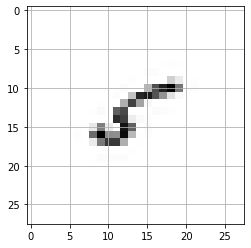

In [7]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid('off')
_ = plt.show()

Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations. Here, we flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and renames the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [9]:
NUM_CLIENTS = 10 #len(emnist_train.client_ids)
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500

def preprocess(dataset):

  def element_fn(element):
    return collections.OrderedDict([
        ('x', tf.reshape(element['pixels'], [-1])),
        ('y', tf.reshape(element['label'], [1])),
    ])

  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
      SHUFFLE_BUFFER).batch(BATCH_SIZE)

Let's verify this worked.

In [10]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(
    lambda x: x.numpy(), iter(preprocessed_example_dataset).next())

In [11]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids]

In [12]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

len(federated_train_data), federated_train_data[0]

(3383,
 <BatchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [13]:
sample_batch['x'][0].reshape((28, 28)).shape

(28, 28)

## Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras
model. Here's an example of a simple model that will suffice for our needs.

In [14]:
def create_compiled_keras_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          10, activation=tf.nn.softmax, kernel_initializer='zeros', input_shape=(784,))])
  
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [15]:
def model_fn():
  keras_model = create_compiled_keras_model()
  return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [16]:
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [18]:
state = iterative_process.initialize()

The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

In [19]:
type(metrics)

tensorflow_federated.python.common_libs.anonymous_tuple.AnonymousTuple

In [20]:
list(zip(metrics, dir(metrics)))

[(0.14578189, 'keras_training_time_client_sum_sec'),
 (2.97196, 'loss'),
 (0.000600338, 'sparse_categorical_accuracy')]

In [21]:
for name in dir(metrics):
    print(f"{name}: {getattr(metrics, name)}")

keras_training_time_client_sum_sec: 0.0006003379821777344
loss: 2.9719600677490234
sparse_categorical_accuracy: 0.14578188955783844


In [22]:
# metrics.
getattr(metrics, name)

0.14578189

In [23]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.18065842986106873,loss=2.775916337966919,keras_training_time_client_sum_sec=0.0006308555603027344>
round  3, metrics=<sparse_categorical_accuracy=0.22211934626102448,loss=2.4514782428741455,keras_training_time_client_sum_sec=0.0006222724914550781>
round  4, metrics=<sparse_categorical_accuracy=0.27407407760620117,loss=2.2914140224456787,keras_training_time_client_sum_sec=0.0006554126739501953>
round  5, metrics=<sparse_categorical_accuracy=0.32695472240448,loss=2.0907809734344482,keras_training_time_client_sum_sec=0.0007643699645996094>
round  6, metrics=<sparse_categorical_accuracy=0.39907407760620117,loss=1.8560289144515991,keras_training_time_client_sum_sec=0.0006082057952880859>
round  7, metrics=<sparse_categorical_accuracy=0.44876542687416077,loss=1.7270830869674683,keras_training_time_client_sum_sec=0.0007834434509277344>
round  8, metrics=<sparse_categorical_accuracy=0.4834362268447876,loss=1.5978162288665771,keras_training_time_

Training loss is decreasing after each round of federated training, indicating
the model is converging. There are some important caveats with these training
metrics, however, see the section on *Evaluation* later in this tutorial.

## Displaying model metrics in TensorBoard
Next, let's visualize the metrics from these federated computations using Tensorboard.

Let's start by creating the directory and the corresponding summary writer to write the metrics to.




In [24]:
# #@test {"skip": true}
# logdir = "/tmp/logs/scalars/training/"
# summary_writer = tf.summary.create_file_writer(logdir)
# state = iterative_process.initialize()

Plot the relevant scalar metrics with the same summary writer.

In [25]:
# #@test {"skip": true}
# with summary_writer.as_default():
#   for round_num in range(1, NUM_ROUNDS):
#     state, metrics = iterative_process.next(state, federated_train_data)
#     for name, value in metrics._asdict().items():
#       tf.compat.v2.summary.scalar(name, value, step=round_num)

Start TensorBoard with the root log directory specified above. It can take a few seconds for the data to load.

In order to view evaluation metrics the same way, you can create a separate eval folder, like "logs/scalars/eval", to write to TensorBoard.

## Customizing the model implementation

Keras is the [recommended high-level model API for TensorFlow](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a), and we encourage using Keras models (via 
`tff.learning.from_keras_model` or
`tff.learning.from_compiled_keras_model`) in TFF whenever possible.

However, `tff.learning` provides a lower-level model interface, `tff.learning.Model`, that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks like `tf.keras.layers`) allows for maximum customization without modifying the internals of the federated learning algorithms.

So let's do it all over again from scratch.

### Defining model variables, forward pass, and metrics

The first step is to identify the TensorFlow variables we're going to work with.
In order to make the following code more legible, let's define a data structure
to represent the entire set. This will include variables such as `weights` and
`bias` that we will train, as well as variables that will hold various
cumulative statistics and counters we will update during training, such as
`loss_sum`, `accuracy_sum`, and `num_examples`.

In [26]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

Here's a method that creates the variables. For the sake of simplicity, we
represent all statistics as `tf.float32`, as that will eliminate the need for
type conversions at a later stage. Wrapping variable initializers as lambdas is
a requirement imposed by
[resource variables](https://www.tensorflow.org/api_docs/python/tf/enable_resource_variables).

In [27]:
def create_mnist_variables():
  return MnistVariables(
      weights = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples = tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum = tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum = tf.Variable(0.0, name='accuracy_sum', trainable=False))

With the variables for model parameters and cumulative statistics in place, we
can now define the forward pass method that computes loss, emits predictions,
and updates the cumulative statistics for a single batch of input data, as
follows.

In [28]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(tf.reduce_sum(
      tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

Next, we define a function that returns a set of local metrics, again using TensorFlow. These are the values (in addition to model updates, which are handled automatically) that are eligible to be aggregated to the server in a federated learning or evaluation process.

Here, we simply return the average `loss` and `accuracy`, as well as the
`num_examples`, which we'll need to correctly weight the contributions from
different users when computing federated aggregates.

In [29]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict([
      ('num_examples', variables.num_examples),
      ('loss', variables.loss_sum / variables.num_examples),
      ('accuracy', variables.accuracy_sum / variables.num_examples)
    ])

Finally, we need to determine how to aggregate the local metrics emitted by each
device via `get_local_mnist_metrics`. This is the only part of the code that isn't written in TensorFlow  - it's a *federated computation* expressed in TFF. If you'd like to
dig deeper, skim over the [custom algorithms](custom_federated_algorithms_1.ipynb)
tutorial, but in most applications, you won't really need to; variants of the
pattern shown below should suffice. Here's what it looks like:


In [30]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return {
      'num_examples': tff.federated_sum(metrics.num_examples),
      'loss': tff.federated_mean(metrics.loss, metrics.num_examples),
      'accuracy': tff.federated_mean(metrics.accuracy, metrics.num_examples)
  }

The input `metrics` argument corresponds to the `OrderedDict` returned by `get_local_mnist_metrics` above, but critically the values are no longer `tf.Tensors` - they are "boxed" as `tff.Value`s, to make it clear you can no longer manipulate them using TensorFlow, but only using TFF's federated operators like `tff.federated_mean` and `tff.federated_sum`.  The returned
dictionary of global aggregates defines the set of metrics which will be available on the server.




### Constructing an instance of `tff.learning.Model`

With all of the above in place, we are ready to construct a model representation
for use with TFF similar to one that's generated for you when you let TFF ingest
a Keras model.

In [31]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict([('x', tf.TensorSpec([None, 784],
                                                        tf.float32)),
                                    ('y', tf.TensorSpec([None, 1], tf.int32))])

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_exmaples)

  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

As you can see, the abstract methods and properties defined by
`tff.learning.Model` corresponds to the code snippets in the preceding section
that introduced the variables and defined the loss and statistics.

Here are a few points worth highlighting:

*   All state that your model will use must be captured as TensorFlow variables,
    as TFF does not use Python at runtime (remember your code should be written
    such that it can be deployed to mobile devices; see the
    [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial for a more
    in-depth commentary on the reasons).
*   Your model should describe what form of data it accepts (`input_spec`), as
    in general, TFF is a strongly-typed environment and wants to determine type
    signatures for all components. Declaring the format of your model's input is
    an essential part of it.
*   Although technically not required, we recommend wrapping all TensorFlow
    logic (forward pass, metric calculations, etc.) as `tf.function`s,
    as this helps ensure the TensorFlow can be serialized, and removes the need
    for explicit control dependencies.


The above is sufficient for evaluation and algorithms like Federated SGD.
However, for Federated Averaging, we need to specify how the model should train
locally on each batch.

In [32]:
class MnistTrainableModel(MnistModel, tff.learning.TrainableModel):

  @tf.function
  def train_on_batch(self, batch):
    with tf.GradientTape() as tape:
      output = self.forward_pass(batch)
    grads = tape.gradient(output.loss, self.trainable_variables)
    optimizer = tf.keras.optimizers.SGD(0.02)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(self.trainable_variables)))
    return output

### Simulating federated training with the new model

With all the above in place, the remainder of the process looks like what we've
seen already - just replace the model constructor with the constructor of our
new model class, and use the two federated computations in the iterative process
you created to cycle through training rounds.

In [33]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistTrainableModel)

In [34]:
state = iterative_process.initialize()

In [35]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<accuracy=0.13456790149211884,loss=3.055020332336426,num_examples=9720.0>


In [36]:
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<accuracy=0.18220163881778717,loss=2.7607266902923584,num_examples=9720.0>
round  3, metrics=<accuracy=0.22520576417446136,loss=2.4871532917022705,num_examples=9720.0>
round  4, metrics=<accuracy=0.26141974329948425,loss=2.3252267837524414,num_examples=9720.0>
round  5, metrics=<accuracy=0.3150205910205841,loss=2.1009483337402344,num_examples=9720.0>
round  6, metrics=<accuracy=0.37109053134918213,loss=1.9115700721740723,num_examples=9720.0>
round  7, metrics=<accuracy=0.4364197552204132,loss=1.767581582069397,num_examples=9720.0>
round  8, metrics=<accuracy=0.47417694330215454,loss=1.6142067909240723,num_examples=9720.0>
round  9, metrics=<accuracy=0.5333333611488342,loss=1.4666272401809692,num_examples=9720.0>
round 10, metrics=<accuracy=0.5591563582420349,loss=1.3803861141204834,num_examples=9720.0>


To see these metrics within TensorBoard, refer to the steps listed above in "Displaying model metrics in TensorBoard".

## Evaluation

All of our experiments so far presented only federated training metrics - the
average metrics over all batches of data trained across all clients in the
round. This introduces the normal concerns about overfitting, especially since
we used the same set of clients on each round for simplicity, but there is an
additional notion of overfitting in training metrics specific to the Federated
Averaging algorithm. This is easiest to see if we imagine each client had a
single batch of data, and we train on that batch for many iterations (epochs).
In this case, the local model will quickly exactly fit to that one batch, and so
the local accuracy metric we average will approach 1.0. Thus, these training
metrics can be taken as a sign that training is progressing, but not much more.

To perform evaluation on federated data, you can construct another *federated
computation* designed for just this purpose, using the
`tff.learning.build_federated_evaluation` function, and passing in your model
constructor as an argument. Note that unlike with Federated Averaging, where
we've used `MnistTrainableModel`, it suffices to pass the `MnistModel`.
Evaluation doesn't perform gradient descent, and there's no need to construct
optimizers.

For experimentation and research, when a centralized test dataset is available,
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb)
demonstrates another evaluation option: taking the trained weights from
federated learning, applying them to a standard Keras model, and then simply
calling `tf.keras.models.Model.evaluate()` on a centralized dataset.

In [37]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

You can inspect the abstract type signature of the evaluation function as follows.

In [38]:
str(evaluation.type_signature)

'(<<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <accuracy=float32@SERVER,loss=float32@SERVER,num_examples=float32@SERVER>)'

No need to be concerned about the details at this point, just be aware that it
takes the following general form, similar to `tff.utils.IterativeProcess.next`
but with two important differences. First, we are not returning server state,
since evaluation doesn't modify the model or any other aspect of state - you can
think of it as stateless. Second, evaluation only needs the model, and doesn't
require any other part of server state that might be associated with training,
such as optimizer variables.

```
SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS
```

Let's invoke evaluation on the latest state we arrived at during training. In
order to extract the latest trained model from the server state, you simply
access the `.model` member, as follows.

In [39]:
train_metrics = evaluation(state.model, federated_train_data)

Here's what we get. Note the numbers look marginally better than what was
reported by the last round of training above. By convention, the training
metrics reported by the iterative training process generally reflect the
performance of the model at the beginning of the training round, so the
evaluation metrics will always be one step ahead.

In [40]:
str(train_metrics)

'<accuracy=0.7355967164039612,loss=1.1525417566299438,num_examples=9720.0>'

Now, let's compile a test sample of federated data and rerun evaluation on the
test data. The data will come from the same sample of real users, but from a
distinct held-out data set.

In [41]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(10,
 <BatchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [42]:
test_metrics = evaluation(state.model, federated_test_data)

In [43]:
str(test_metrics)

'<accuracy=0.6896551847457886,loss=1.2701549530029297,num_examples=1160.0>'

This concludes the tutorial. We encourage you to play with the
parameters (e.g., batch sizes, number of users, epochs, learning rates, etc.), to modify the code above to simulate training on random samples of users in
each round, and to explore the other tutorials we've developed.